# Validating RAS Mapper Layers and Terrain Files

### Validation Framework

This notebook demonstrates the **ras-commander validation framework** for pre-flight checks and data quality assurance. The framework uses three core classes:

- **ValidationSeverity**: Severity levels (INFO < WARNING < ERROR < CRITICAL)
- **ValidationResult**: Single validation check result
- **ValidationReport**: Aggregation of multiple validation results

**Why Validation Matters**:
- Catch errors **before** expensive HEC-RAS execution
- Ensure data quality for reliable results
- Document assumptions and limitations
- Enable graceful degradation when optional data missing

### Reference
- **Validation Patterns**: `.claude/rules/validation/validation-patterns.md`
- **RasMap API**: `ras_commander/RasMap.py` (validation methods)
- [FEMA Data Capture Standards](https://www.fema.gov/flood-maps/guidance-partners/data-capture-standards)

### LLM Forward Principle
Validation creates **audit trail before execution**:
1. **Pre-flight checks documented**: All validation results logged
2. **Data quality issues flagged**: Warnings visible to reviewers
3. **Graceful degradation**: System continues with reduced functionality when appropriate

**Professional Context**: Validation is not a substitute for engineering judgment. Use validation to identify issues, then apply professional expertise to determine appropriate actions.

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
# Set USE_LOCAL_SOURCE based on your setup:
#   True  = Use local source code (for developers editing ras-commander)  
#   False = Use pip-installed package (for users)
# =============================================================================

USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS (set to True for local development)

# -----------------------------------------------------------------------------
if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)  # Parent of examples/ = repo root
    if local_path not in sys.path:
        sys.path.insert(0, local_path)  # Insert at position 0 = highest priority
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander (will use local or pip based on toggle above)
from ras_commander import RasExamples, RasMap, ValidationSeverity, ras

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📁 LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
✓ Loaded: c:\GH\ras-commander\ras_commander\__init__.py


### Understanding Severity Levels

**ValidationSeverity Classification**:

**INFO** - Informational (operation proceeds normally):
- File metadata (size, format, creation date)
- Successful validation checks
- Data statistics and summaries

**WARNING** - Non-critical issue (operation may succeed):
- Large files (performance impact)
- Data extends beyond expected range
- Missing optional datasets
- Unusual but valid configurations

**ERROR** - Critical issue (operation will likely fail):
- Required files not found
- Invalid data format
- Missing required datasets
- Coordinate reference system undefined

**CRITICAL** - Blocking issue (cannot proceed):
- File corrupted or unreadable
- Incompatible file formats
- Security violations

**Decision Matrix**:
```python
report = RasMap.check_layer(terrain_file)

if report.is_valid:
    # No ERROR or CRITICAL - safe to proceed
    execute_mapping()
elif report.has_warnings:
    # Warnings only - proceed with caution
    logger.warning("Quality issues detected - review before use")
    execute_mapping()
else:
    # Errors or critical - cannot proceed
    logger.error("Validation failed - fix issues before proceeding")
    report.print_report(show_passed=False)
    raise ValueError("Invalid terrain layer")
```

### Validation Best Practices

**1. Pre-Flight Checks**
Always validate inputs before expensive operations:
```python
# Validate terrain before mapping
report = RasMap.check_layer(terrain_file, layer_type='terrain')
if not report.is_valid:
    print("❌ Terrain validation failed - fix before mapping")
    report.print_report(show_passed=False)
    sys.exit(1)

# Proceed with mapping
execute_mapping(terrain_file)
```

**2. Detailed vs Boolean Methods**
- **Detailed** (`check_*`): Returns ValidationResult/ValidationReport with full diagnostics
- **Boolean** (`is_valid_*`): Returns True/False for simple checks

Use detailed when you need diagnostics, boolean for simple pass/fail.

**3. Graceful Degradation**
```python
# Optional land cover layer
if RasMap.is_valid_layer(land_cover_file):
    print("✓ Using land cover for Manning's n")
    roughness = compute_from_land_cover(land_cover_file)
else:
    print("⚠️ Land cover invalid - using default Manning's n")
    roughness = default_mannings_n
```

**4. Document Assumptions**
Always log validation results for audit trail:
```python
report = RasMap.check_layer(terrain_file)
report.print_report()  # Document all checks, not just failures

# Save to file for professional review
with open('validation_report.txt', 'w') as f:
    f.write(str(report))
```

### Professional Review Checklist
- [ ] All input layers validated before use
- [ ] Validation reports saved for review
- [ ] Warnings reviewed and dispositioned
- [ ] Errors fixed or exceptions documented
- [ ] Assumptions clearly stated
- [ ] Graceful degradation documented (if applicable)

## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# HDF Analysis Settings
PLAN = "01"                       # Plan number (for HDF file path)
TIME_INDEX = -1                   # Time step index (-1 = last)
PROFILE = "Max"                   # Profile name for steady analysis

---

## Overview

This notebook demonstrates the RAS Mapper layer validation framework in ras-commander. RAS Mapper uses various geospatial layers (terrain, land cover, boundaries) to visualize and configure HEC-RAS models. Validating these layers ensures:

- Files exist and are readable
- Formats are supported (GeoJSON, Shapefile, GeoTIFF, HDF)
- Coordinate reference systems (CRS) are defined
- Raster metadata is valid
- Spatial extents cover the model domain

The validation framework provides:
- Format validation
- CRS validation
- Raster metadata checks
- Spatial extent verification
- Specialized terrain and land cover validation
- Comprehensive validation reports

We'll use the **Muncie** example project which includes RAS Mapper layers.

---

## Extract Example Project

In [3]:
# Extract Muncie project (contains RAS Mapper configuration)
project_path = RasExamples.extract_project("BaldEagleCrkMulti2D")
print(f"\nProject extracted to: {project_path}")

2026-01-12 23:58:29 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2026-01-12 23:58:29 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-12 23:58:29 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-12 23:58:29 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-12 23:58:29 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2026-01-12 23:58:33 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D



Project extracted to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D


In [4]:
# Find geospatial files in the project
from pathlib import Path

# Common geospatial file extensions
geo_extensions = ['*.tif', '*.tiff', '*.shp', '*.geojson', '*.json', '*.hdf', '*.h5']

geo_files = []
for pattern in geo_extensions:
    geo_files.extend(project_path.glob(pattern))
    # Also check subdirectories
    geo_files.extend(project_path.glob(f"*/{pattern}"))
    geo_files.extend(project_path.glob(f"*/*/{pattern}"))

print(f"Found {len(geo_files)} geospatial file(s):")
for geo_file in geo_files[:10]:  # Show first 10
    size_kb = geo_file.stat().st_size / 1024
    print(f"  - {geo_file.relative_to(project_path)} ({size_kb:.2f} KB)")
if len(geo_files) > 10:
    print(f"  ... and {len(geo_files) - 10} more")

Found 34 geospatial file(s):
  - Land Classification\LandCover.tif (12955.67 KB)
  - Soils Data\Hydrologic Soil Groups.tif (10196.48 KB)
  - Terrain\Terrain50.baldeagledem.tif (173985.99 KB)
  - Terrain\Terrain50.dtm_20ft.tif (11063.01 KB)
  - GISData\MainChannelBanks.shp (28.14 KB)
  - NLD\Lock_Haven_CenterLine.shp (11.56 KB)
  - NLD\Lock_Haven_Floodwall.shp (0.10 KB)
  - NLD\Lock_Haven_LeveedArea.shp (12.96 KB)
  - BaldEagleDamBrk.g01.hdf (4894.39 KB)
  - BaldEagleDamBrk.g02.hdf (1900.81 KB)
  ... and 24 more


In [5]:
# Look for terrain files specifically
terrain_files = [f for f in geo_files if 'terrain' in f.name.lower() or f.suffix.lower() in ['.tif', '.tiff']]

if terrain_files:
    test_terrain_file = terrain_files[0]
    print(f"Using terrain file: {test_terrain_file.name}")
else:
    print("⚠️ No terrain files found - will use synthetic examples")
    test_terrain_file = project_path / "terrain.tif"  # For examples

Using terrain file: LandCover.tif


---

## 1. Format Validation: `check_layer_format()`

Validates that layer files exist, are readable, and have supported formats.

In [6]:
# Example 1: Valid terrain file (GeoTIFF)
if terrain_files:
    result = RasMap.check_layer_format(test_terrain_file)
    print(f"File: {test_terrain_file.name}")
    print(f"Result: {result}")
    print(f"\nDetails:")
    for key, value in result.details.items():
        print(f"  {key}: {value}")

File: LandCover.tif
Result: [INFO] [PASS] geotiff_format: GeoTIFF format valid (14765x10318, 1 bands)

Details:
  width: 14765
  height: 10318
  bands: 1
  dtype: int32
  crs: EPSG:2271
  resolution: (10.0, 10.0)
  bounds: BoundingBox(left=1952353.7000038475, bottom=276820.8446467547, right=2100003.7000038475, top=380000.8446467547)


In [7]:
# Example 2: Check various file types
file_types_to_check = {
    'GeoTIFF': [f for f in geo_files if f.suffix.lower() in ['.tif', '.tiff']],
    'Shapefile': [f for f in geo_files if f.suffix.lower() == '.shp'],
    'GeoJSON': [f for f in geo_files if f.suffix.lower() in ['.geojson', '.json']],
    'HDF': [f for f in geo_files if f.suffix.lower() in ['.hdf', '.h5']]
}

print("Format validation by file type:\n")
for file_type, files in file_types_to_check.items():
    if files:
        test_file = files[0]
        result = RasMap.check_layer_format(test_file)
        status = "✓" if result.passed else "✗"
        print(f"{status} {file_type}: {test_file.name}")
        print(f"  {result.message}")
        if result.severity == ValidationSeverity.WARNING:
            print(f"  ⚠️ {result.severity.value.upper()}")
        print()

Format validation by file type:

✓ GeoTIFF: LandCover.tif
  GeoTIFF format valid (14765x10318, 1 bands)

✓ Shapefile: MainChannelBanks.shp
  Shapefile format valid (2 features)

✓ HDF: BaldEagleDamBrk.g01.hdf
  HDF format valid (1 root groups)



In [8]:
# Example 3: Invalid file (doesn't exist)
nonexistent_file = project_path / "missing_terrain.tif"

result = RasMap.check_layer_format(nonexistent_file)
print(f"File: {nonexistent_file.name}")
print(f"Result: {result}")
print(f"Passed: {result.passed}")
print(f"Severity: {result.severity.value}")

File: missing_terrain.tif
Result: [ERROR] [FAIL] file_existence: File not found: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\missing_terrain.tif
Passed: False
Severity: error


---

## 2. CRS Validation: `check_layer_crs()`

Validates coordinate reference system and checks compatibility with project CRS.

In [9]:
# Example 1: Check terrain CRS
if terrain_files:
    result = RasMap.check_layer_crs(test_terrain_file)
    print(f"File: {test_terrain_file.name}")
    print(f"Result: {result}")
    print(f"\nDetails:")
    for key, value in result.details.items():
        print(f"  {key}: {value}")

File: LandCover.tif
Result: [INFO] [PASS] crs_validation: CRS valid: EPSG:2271

Details:
  crs: EPSG:2271


In [10]:
# Example 2: Check CRS compatibility with expected projection
if terrain_files:
    # First, get the CRS from the terrain file
    result1 = RasMap.check_layer_crs(test_terrain_file)
    
    if result1.passed and 'crs' in result1.details:
        terrain_crs = result1.details['crs']
        print(f"Terrain CRS: {terrain_crs}")
        
        # Extract EPSG code as integer (e.g., "EPSG:2965" -> 2965)
        epsg_code = None
        if terrain_crs and terrain_crs.startswith("EPSG:"):
            try:
                epsg_code = int(terrain_crs.split(":")[1])
            except (ValueError, IndexError):
                pass
        
        # Check if another file matches
        if len(geo_files) > 1 and epsg_code:
            other_file = [f for f in geo_files if f != test_terrain_file][0]
            result2 = RasMap.check_layer_crs(other_file, expected_epsg=epsg_code)
            
            print(f"\nComparing with: {other_file.name}")
            print(f"Result: {result2}")
            if result2.passed:
                print("  CRS matches terrain file")
            else:
                print("  CRS mismatch - may need reprojection")

Terrain CRS: EPSG:2271

Comparing with: Hydrologic Soil Groups.tif
Result: [INFO] [PASS] crs_validation: CRS valid: EPSG:2271
  CRS matches terrain file


---

## 3. Raster Metadata: `check_raster_metadata()`

Validates raster-specific properties (dimensions, resolution, no-data values).

In [11]:
# Example 1: Check terrain raster metadata
if terrain_files:
    results = RasMap.check_raster_metadata(test_terrain_file)
    print(f"File: {test_terrain_file.name}")
    print(f"Number of checks: {len(results)}")
    print(f"\nResults:")
    for result in results:
        status = "PASS" if result.passed else "FAIL"
        print(f"  [{status}] {result.check_name}: {result.message}")
        if result.details:
            for key, value in result.details.items():
                print(f"      {key}: {value}")

File: LandCover.tif
Number of checks: 3

Results:
  [PASS] resolution_check: Raster resolution acceptable: 10.00 meters
      resolution: 10.0
  [PASS] nodata_check: Raster nodata acceptable: 0.0%
      nodata_percent: 0.0
  [PASS] extent_info: Raster extent: (1952353.70, 276820.84, 2100003.70, 380000.84)
      bounds: (1952353.7000038475, 276820.8446467547, 2100003.7000038475, 380000.8446467547)


In [12]:
# Example 2: Check multiple raster files
raster_files = [f for f in geo_files if f.suffix.lower() in ['.tif', '.tiff']]

if raster_files:
    print(f"Raster metadata for {len(raster_files)} file(s):\n")
    
    for raster_file in raster_files[:3]:  # Check first 3
        results = RasMap.check_raster_metadata(raster_file)
        print(f"File: {raster_file.name}")
        
        # Extract key metrics from results
        for result in results:
            if result.check_name == 'resolution_check' and result.details:
                print(f"  Resolution: {result.details.get('resolution', 'N/A')} meters")
            elif result.check_name == 'nodata_check' and result.details:
                print(f"  No-data: {result.details.get('nodata_percent', 'N/A'):.1f}%")
            elif result.check_name == 'extent_info' and result.details:
                bounds = result.details.get('bounds')
                if bounds:
                    print(f"  Extent: {bounds[0]:.2f}, {bounds[1]:.2f} to {bounds[2]:.2f}, {bounds[3]:.2f}")
        print()

Raster metadata for 4 file(s):

File: LandCover.tif
  Resolution: 10.0 meters
  No-data: 0.0%
  Extent: 1952353.70, 276820.84 to 2100003.70, 380000.84

File: Hydrologic Soil Groups.tif
  Resolution: 10.0 meters
  No-data: 0.0%
  Extent: 1952353.70, 276820.84 to 2100003.70, 380000.84

File: Terrain50.baldeagledem.tif
  Resolution: 36.504512049933 meters
  No-data: 0.8%
  Extent: 1834327.20, 162918.81 to 2149835.69, 414872.95



---

## 4. Spatial Extent: `check_spatial_extent()`

Validates spatial coverage and checks overlap with expected domain.

In [13]:
# Example 1: Check terrain spatial extent
# First we need to get the layer's bounds to establish a model extent
if terrain_files:
    import rasterio
    
    # Get bounds of the terrain file
    with rasterio.open(test_terrain_file) as src:
        terrain_bounds = src.bounds
        model_extent = (terrain_bounds.left, terrain_bounds.bottom, 
                       terrain_bounds.right, terrain_bounds.top)
    
    print(f"File: {test_terrain_file.name}")
    print(f"Model extent (from terrain): {model_extent}")
    
    # Now check spatial extent with that as the reference
    result = RasMap.check_spatial_extent(test_terrain_file, model_extent)
    print(f"\nResult: {result}")
    print(f"\nDetails:")
    for key, value in result.details.items():
        print(f"  {key}: {value}")

File: LandCover.tif
Model extent (from terrain): (1952353.7000038475, 276820.8446467547, 2100003.7000038475, 380000.8446467547)

Result: [INFO] [PASS] spatial_coverage: Layer covers 100.0% of model domain

Details:
  coverage_percent: 100.0


In [14]:
# Example 2: Check coverage overlap between layers
if len(geo_files) >= 2 and terrain_files:
    import rasterio
    
    # Use terrain as the model extent reference
    with rasterio.open(test_terrain_file) as src:
        terrain_bounds = src.bounds
        model_extent = (terrain_bounds.left, terrain_bounds.bottom,
                       terrain_bounds.right, terrain_bounds.top)
    
    file1 = test_terrain_file
    file2 = [f for f in geo_files if f != test_terrain_file][0]
    
    print(f"Checking overlap:\n")
    print(f"Reference (model extent from terrain): {test_terrain_file.name}")
    print(f"  Bounds: minx={model_extent[0]:.2f}, miny={model_extent[1]:.2f}, maxx={model_extent[2]:.2f}, maxy={model_extent[3]:.2f}")
    
    # Check if second file overlaps with model extent
    result = RasMap.check_spatial_extent(file2, model_extent)
    
    print(f"\nFile 2: {file2.name}")
    print(f"  {result}")
    
    if result.passed:
        print(f"\n  Files have overlapping coverage")
        if result.details and 'coverage_percent' in result.details:
            print(f"  Coverage: {result.details['coverage_percent']:.1f}%")
    else:
        print(f"\n  Coverage mismatch detected")

Checking overlap:

Reference (model extent from terrain): LandCover.tif
  Bounds: minx=1952353.70, miny=276820.84, maxx=2100003.70, maxy=380000.84

File 2: Hydrologic Soil Groups.tif
  [INFO] [PASS] spatial_coverage: Layer covers 100.0% of model domain

  Files have overlapping coverage
  Coverage: 100.0%


---

## 5. Terrain Layer Validation: `check_terrain_layer()`

Specialized validation for terrain/elevation layers.

In [15]:
# Example 1: Comprehensive terrain validation
# The check_terrain_layer method validates terrain layers in a rasmap file

rasmap_files = list(project_path.glob("*.rasmap"))

if rasmap_files and terrain_files:
    rasmap_file = rasmap_files[0]
    print(f"RASMapper file: {rasmap_file.name}")
    
    # Get terrain names from the rasmap
    terrain_names = RasMap.get_terrain_names(rasmap_file)
    
    if terrain_names:
        layer_name = terrain_names[0]
        print(f"Terrain layer found: {layer_name}")
        
        result = RasMap.check_terrain_layer(rasmap_file, layer_name)
        print(f"\nResult: {result}")
        print(f"\nDetails:")
        for key, value in result.details.items():
            if isinstance(value, dict):
                print(f"  {key}:")
                for sub_key, sub_val in value.items():
                    print(f"    {sub_key}: {sub_val}")
            else:
                print(f"  {key}: {value}")
    else:
        print("No terrain layers found in rasmap")
else:
    print("No rasmap file found - skipping terrain layer validation")
    print("\nTo validate terrain layers in a rasmap:")
    print("  result = RasMap.check_terrain_layer('project.rasmap', 'Terrain_Name')")

2026-01-12 23:58:43 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']
2026-01-12 23:58:43 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']


RASMapper file: BaldEagleDamBrk.rasmap
Terrain layer found: Terrain50

Result: [INFO] [PASS] terrain_layer_validation: Terrain layer 'Terrain50' found in rasmap

Details:
  layer_name: Terrain50


In [16]:
# Example 2: Validate elevation range using rasterio directly
# Since check_terrain_layer works with rasmap, let's use rasterio for elevation stats
if terrain_files:
    import rasterio
    import numpy as np
    
    with rasterio.open(test_terrain_file) as src:
        data = src.read(1)  # Read first band
        nodata = src.nodata
        
        # Mask nodata values
        if nodata is not None:
            valid_data = data[data != nodata]
        else:
            valid_data = data.flatten()
        
        # Calculate statistics
        min_elev = float(np.min(valid_data)) if len(valid_data) > 0 else None
        max_elev = float(np.max(valid_data)) if len(valid_data) > 0 else None
        mean_elev = float(np.mean(valid_data)) if len(valid_data) > 0 else None
        
    print(f"Terrain elevation statistics for {test_terrain_file.name}:\n")
    print(f"  Minimum: {min_elev:.2f}" if min_elev is not None else "  Minimum: N/A")
    print(f"  Maximum: {max_elev:.2f}" if max_elev is not None else "  Maximum: N/A")
    print(f"  Mean: {mean_elev:.2f}" if mean_elev is not None else "  Mean: N/A")
    
    # Check for reasonable range
    if min_elev is not None and max_elev is not None:
        if min_elev < -500 or max_elev > 15000:
            print("\n  WARNING: Elevation range may be unrealistic for US terrain")
            print("     Check units (should be feet or meters, not mm or other)")
        else:
            print("\n  Elevation range appears reasonable")

Terrain elevation statistics for LandCover.tif:

  Minimum: 11.00
  Maximum: 95.00
  Mean: 46.75

  Elevation range appears reasonable


---

## 6. Land Cover Validation: `check_land_cover_layer()`

Specialized validation for land cover/Manning's n layers.

In [17]:
# Example 1: Check land cover layer
# check_land_cover_layer validates land cover configuration in a rasmap file
rasmap_files = list(project_path.glob("*.rasmap"))

# For land cover, we need to know the layer name
# Since there's no get_land_cover_names method, we'll demonstrate the API pattern
if rasmap_files:
    rasmap_file = rasmap_files[0]
    print(f"RASMapper file: {rasmap_file.name}")
    
    # Demonstrate with a placeholder - in real use you'd know your layer name
    land_cover_layer = "LandCover"  # Example layer name
    
    print(f"\nLand cover validation example:")
    print(f"  result = RasMap.check_land_cover_layer('{rasmap_file.name}', '{land_cover_layer}')")
    print(f"\nLand cover validation checks:")
    print("  - Layer exists in rasmap")
    print("  - File format (typically raster)")  
    print("  - CRS matches terrain")
    print("  - Categorical data (land use classes)")
    print("  - Spatial coverage matches model domain")
else:
    print("No rasmap file found in project")
    print("\nTo validate land cover layers in a rasmap:")
    print("  result = RasMap.check_land_cover_layer('project.rasmap', 'LandCover_Name')")

RASMapper file: BaldEagleDamBrk.rasmap

Land cover validation example:
  result = RasMap.check_land_cover_layer('BaldEagleDamBrk.rasmap', 'LandCover')

Land cover validation checks:
  - Layer exists in rasmap
  - File format (typically raster)
  - CRS matches terrain
  - Categorical data (land use classes)
  - Spatial coverage matches model domain


---

## 7. Comprehensive Layer Validation: `check_layer()`

Performs all applicable validation checks and returns a comprehensive report.

In [18]:
# Example 1: Comprehensive validation of a terrain layer in a rasmap file
rasmap_files = list(project_path.glob("*.rasmap"))

if rasmap_files:
    rasmap_file = rasmap_files[0]
    print(f"RASMapper file: {rasmap_file.name}")
    
    # Get terrain names
    terrain_names = RasMap.get_terrain_names(rasmap_file)
    
    if terrain_names:
        layer_name = terrain_names[0]
        layer_type = "Terrain"
        
        print(f"\nValidating layer: {layer_name}")
        print(f"Layer type: {layer_type}")
        
        report = RasMap.check_layer(
            rasmap_path=rasmap_file,
            layer_name=layer_name,
            layer_type=layer_type
        )
        
        print(f"\nReport summary: {report.summary}")
        print(f"Is valid: {report.is_valid}")
        print(f"Has warnings: {report.has_warnings}")
        
        # Print formatted report
        print("\nDetailed Report:")
        report.print_report(show_passed=True)
    else:
        print("No terrain layers found in rasmap file")
else:
    print("No rasmap file found in project")
    print("\nTo validate layers in a rasmap:")
    print("  report = RasMap.check_layer('project.rasmap', 'Layer_Name', 'Terrain')")

2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']
2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']


RASMapper file: BaldEagleDamBrk.rasmap

Validating layer: Terrain50
Layer type: Terrain

Report summary: 1 info, 0 warnings, 0 errors, 0 critical
Is valid: True
Has warnings: False

Detailed Report:

Validation Report: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap - Terrain50
Timestamp: 2026-01-12T23:58:46.360751

Summary: 1 info, 0 warnings, 0 errors, 0 critical
Overall Status: VALID

Detailed Results:

[INFO] [PASS] terrain_layer_validation: Terrain layer 'Terrain50' found in rasmap
  layer_name: Terrain50




In [19]:
# Example 2: Filter validation results by severity
rasmap_files = list(project_path.glob("*.rasmap"))

if rasmap_files:
    rasmap_file = rasmap_files[0]
    terrain_names = RasMap.get_terrain_names(rasmap_file)
    
    if terrain_names:
        layer_name = terrain_names[0]
        layer_type = "Terrain"
        
        report = RasMap.check_layer(rasmap_file, layer_name, layer_type)
        
        # Get only errors
        errors = report.get_results_by_severity(ValidationSeverity.ERROR)
        print(f"Errors found: {len(errors)}")
        for error in errors:
            print(f"  [FAIL] {error}")
        
        # Get only warnings
        warnings = report.get_results_by_severity(ValidationSeverity.WARNING)
        print(f"\nWarnings found: {len(warnings)}")
        for warning in warnings:
            print(f"  [WARN] {warning}")
        
        # Get info messages
        info = report.get_results_by_severity(ValidationSeverity.INFO)
        print(f"\nInfo messages: {len(info)}")
        for msg in info:
            print(f"  [INFO] {msg}")
    else:
        print("No terrain layers found")
else:
    print("No rasmap file found - skipping severity filtering example")

2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']
2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']


Errors found: 0

Warnings found: 0

Info messages: 1
  [INFO] [INFO] [PASS] terrain_layer_validation: Terrain layer 'Terrain50' found in rasmap


---

## 8. Boolean Convenience: `is_valid_layer()`

Quick boolean check for layer validity.

In [20]:
# Example: Quick validation of terrain layers in a rasmap file
rasmap_files = list(project_path.glob("*.rasmap"))

if rasmap_files:
    rasmap_file = rasmap_files[0]
    terrain_names = RasMap.get_terrain_names(rasmap_file)
    
    print(f"Quick validation of terrain layers in {rasmap_file.name}:\n")
    
    for layer_name in terrain_names:
        layer_type = "Terrain"
        
        is_valid = RasMap.is_valid_layer(rasmap_file, layer_name, layer_type)
        status = "VALID" if is_valid else "INVALID"
        print(f"{status}: {layer_name} ({layer_type})")
    
    if not terrain_names:
        print("No terrain layers found in rasmap")
else:
    print("No rasmap file found in project")
    print("\nQuick validation example:")
    print("  is_valid = RasMap.is_valid_layer('project.rasmap', 'Terrain_2024', 'Terrain')")

2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']
2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']


Quick validation of terrain layers in BaldEagleDamBrk.rasmap:

VALID: Terrain50 (Terrain)


---

## 9. Practical Use Case: Pre-Flight Check for Model Setup

Validate all required RAS Mapper layers before model setup.

In [21]:
# Simulate pre-flight check for model setup
print("=" * 80)
print("PRE-FLIGHT CHECK: RAS Mapper Layer Validation")
print("=" * 80)

rasmap_files = list(project_path.glob("*.rasmap"))

if rasmap_files:
    rasmap_file = rasmap_files[0]
    print(f"\nRASMapper file: {rasmap_file.name}")
    
    # Get terrain layers
    terrain_names = RasMap.get_terrain_names(rasmap_file)
    all_valid = True
    
    for layer_name in terrain_names:
        layer_type = "Terrain"
        
        print(f"\n{'='*80}")
        print(f"Checking: {layer_name} ({layer_type})")
        print(f"{'='*80}")
        
        # Quick check
        is_valid = RasMap.is_valid_layer(rasmap_file, layer_name, layer_type)
        
        if is_valid:
            print(f"  PASS")
        else:
            print(f"  FAIL - running detailed diagnostics...")
            
            # Get detailed report
            report = RasMap.check_layer(rasmap_file, layer_name, layer_type)
            report.print_report(show_passed=False)
            
            all_valid = False

    if not terrain_names:
        print("\n  No terrain layers found in rasmap")
        all_valid = False

    print("\n" + "=" * 80)
    if all_valid:
        print("PRE-FLIGHT CHECK PASSED - All terrain layers valid")
        print("  Ready to configure RAS Mapper")
    else:
        print("PRE-FLIGHT CHECK FAILED - Fix layer issues before proceeding")
    print("=" * 80)
else:
    print("\nNo rasmap file found in project")
    print("\nPre-flight check requires a .rasmap file with configured layers")

2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']
2026-01-12 23:58:46 - ras_commander.RasMap - INFO - Extracted terrain names: ['Terrain50']


PRE-FLIGHT CHECK: RAS Mapper Layer Validation

RASMapper file: BaldEagleDamBrk.rasmap

Checking: Terrain50 (Terrain)
  PASS

PRE-FLIGHT CHECK PASSED - All terrain layers valid
  Ready to configure RAS Mapper


---

## 10. Visualization: Layer Extent Comparison (Optional)

Visualize spatial extents of multiple layers to verify coverage.

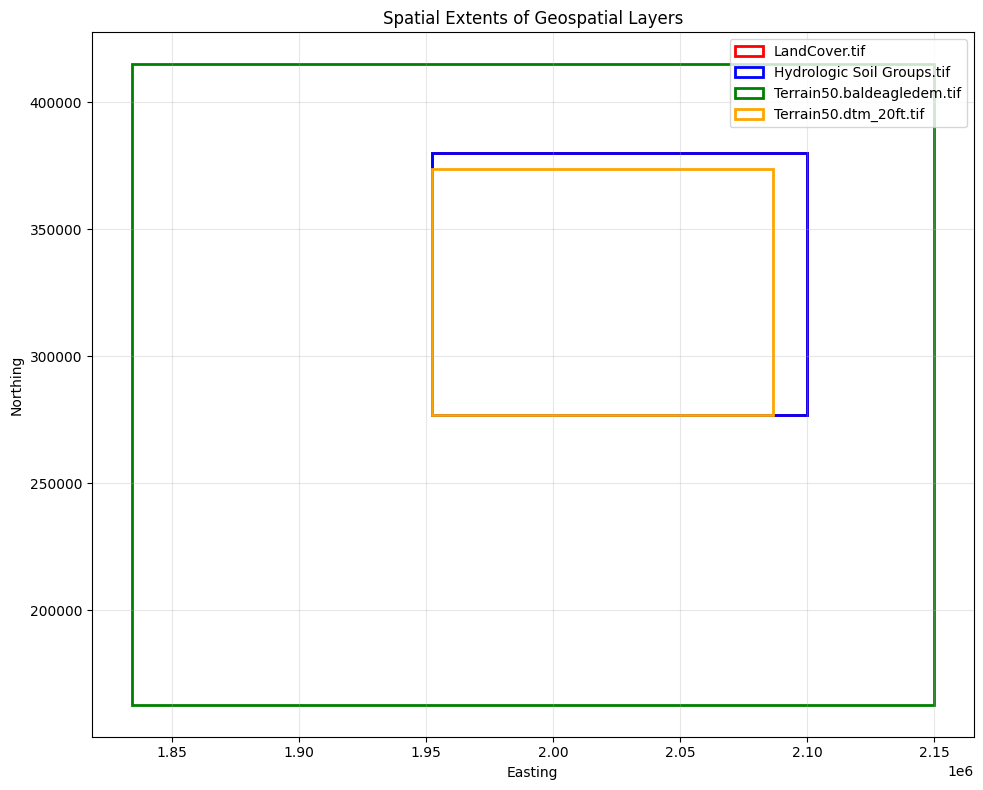


Extent visualization complete
  Overlapping rectangles indicate good coverage alignment


In [22]:
# Optional: Visualize layer extents using matplotlib and rasterio
try:
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import rasterio
    
    raster_files = [f for f in geo_files if f.suffix.lower() in ['.tif', '.tiff']]
    
    if raster_files:
        fig, ax = plt.subplots(figsize=(10, 8))
        
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        
        for i, raster_file in enumerate(raster_files[:5]):  # Plot first 5
            try:
                with rasterio.open(raster_file) as src:
                    bounds = src.bounds
                    
                    # Extract bounds
                    minx = bounds.left
                    miny = bounds.bottom
                    maxx = bounds.right
                    maxy = bounds.top
                    
                    width = maxx - minx
                    height = maxy - miny
                    
                    # Draw rectangle
                    rect = patches.Rectangle(
                        (minx, miny), width, height,
                        linewidth=2, edgecolor=colors[i % len(colors)],
                        facecolor='none', label=raster_file.name
                    )
                    ax.add_patch(rect)
            except Exception as e:
                print(f"Could not read {raster_file.name}: {e}")
        
        ax.set_xlabel('Easting')
        ax.set_ylabel('Northing')
        ax.set_title('Spatial Extents of Geospatial Layers')
        ax.legend(loc='upper right')
        ax.autoscale()
        ax.set_aspect('equal')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nExtent visualization complete")
        print("  Overlapping rectangles indicate good coverage alignment")
    else:
        print("No raster files found for visualization")
    
except ImportError as e:
    print(f"Visualization dependencies not available: {e}")

---

## Cleanup

In [23]:
# Clean up extracted project
import shutil

if project_path.parent.name == "example_projects":
    shutil.rmtree(project_path.parent, ignore_errors=True)
    print("✓ Cleaned up example projects")

✓ Cleaned up example projects


---

## Summary

This notebook demonstrated the RAS Mapper layer validation framework:

**Individual Validation Methods**:
- `check_layer_format()` - Validates file format and accessibility
- `check_layer_crs()` - Validates coordinate reference system
- `check_raster_metadata()` - Validates raster properties
- `check_spatial_extent()` - Validates spatial coverage

**Specialized Validations**:
- `check_terrain_layer()` - Terrain-specific validation
- `check_land_cover_layer()` - Land cover-specific validation

**Comprehensive Validation**:
- `check_layer()` - Runs all applicable checks, returns ValidationReport

**Boolean Convenience**:
- `is_valid_layer()` - Quick validity check

**Validation Reports**:
- Filter by severity (INFO, WARNING, ERROR, CRITICAL)
- Get failed checks
- Print formatted reports

Use these tools to ensure RAS Mapper layers are valid before model setup and execution!